# AlphaZero version 9

This AlphaZero version starts from the weights of version 7 and is trained on augmented StageFour data. This is mostly about trying out data augmentation.

In [1]:
import sys
sys.path.append('..')

import numpy as np
import tensorflow as tf
from tensorflow.python import debug as tf_debug

from keras.callbacks import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.initializers import *
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
import keras.backend as K
from keras.regularizers import l2
from keras.engine.topology import Layer

from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline
import random
import gc

from LineFilterLayer import LineFilterLayer
from ValueLayer import ValueLayer
from AugmentationSequence import AugmentationSequence

modelPath = 'model/alphaZeroV9.h5'
baseModelPath = 'model/alphaZeroV7.h5'

datasetPath = 'StageFour-AlphaZeroV7-128-7x6-18:36-24_05_2018.npz'

Using TensorFlow backend.


In [2]:
print(K.image_data_format()) 
# expected output: channels_last

channels_last


In [3]:
def dotsAndBoxesToCategorical(inputData):
    inp = np.copy(inputData)
    inp[inp == 255] = 1 # Line - comes first so that target data only has two categories
    inp[inp == 65] = 2 # Box A
    inp[inp == 150] = 3 # Box B
    inp[inp == 215] = 4 # Dot
    cat = to_categorical(inp)
    newShape = inp.shape + (cat.shape[-1],)
    return cat.reshape(newShape)

In [4]:
def imgSizeToBoxes(x):
    return (x-3)/2

def lineFilterMatrixNP(imgWidth,imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=np.bool)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = 1
    return mat


In [5]:
def loadRawPVDataset(datasetPath):
    rawDataset = np.load(datasetPath)
    
    x_input = rawDataset['input']
    y_policy = rawDataset['policy']
    y_value = rawDataset['value']
    
    return (x_input, y_policy, y_value)

def process_input(x_input):
    return dotsAndBoxesToCategorical(x_input)

def process_policy(y_policy):
    y_policy = y_policy[:,lineFilterMatrixNP(y_policy.shape[-1], y_policy.shape[-2])]
    y_policy /= 255
    return y_policy

np.set_printoptions(precision=2)
(x_input_raw, y_policy_raw, y_value_raw) = loadRawPVDataset(datasetPath)

In [6]:
print(x_input_raw.shape)
print(y_policy_raw.shape)
print(y_value_raw.shape)
print("raw input:")
print(x_input_raw[0])
print("raw policy:")
print(y_policy_raw[0])
print('raw value:')
print(y_value_raw[0])

(128, 15, 17)
(128, 15, 17)
(128, 1)
raw input:
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215   0 215 255 215 255 215 255 215 255 215   0 215 255 215   0]
 [  0 255   0 255 150 255  65 255  65 255   0   0   0 255  65 255   0]
 [  0 215   0 215 255 215 255 215 255 215   0 215 255 215 255 215   0]
 [  0 255   0 255 150 255  65 255  65 255   0 255   0   0   0 255   0]
 [  0 215   0 215 255 215 255 215 255 215   0 215   0 215   0 215   0]
 [  0 255   0 255 150 255  65 255  65 255   0 255   0 255   0   0   0]
 [  0 215   0 215 255 215 255 215 255 215   0 215   0 215 255 215   0]
 [  0 255   0 255   0   0   0   0   0   0   0 255   0   0   0   0   0]
 [  0 215   0 215   0 215 255 215 255 215 255 215 255 215 255 215   0]
 [  0   0   0 255   0   0   0 255   0   0   0   0   0   0   0   0   0]
 [  0 215 255 215 255 215   0 215   0 215 255 215 255 215 255 215   0]
 [  0 255  65 255  65 255   0 255   0   0   0 255 150 255 150 255   0]
 [  0 215 255 215 255 215   0

In [7]:
imgWidth = x_input_raw.shape[-1]
imgHeight = x_input_raw.shape[-2]
# LineFilterLayer has to be set before loading the model
LineFilterLayer.imgWidth = imgWidth
LineFilterLayer.imgHeight = imgHeight
# ValueLayer has to be set before loading the model
ValueLayer.imgWidth = imgWidth
ValueLayer.imgHeight = imgHeight

model = load_model(baseModelPath,
                   custom_objects={'LineFilterLayer':LineFilterLayer,
                   'ValueLayer':ValueLayer})

model.summary()

LineFilterLayer with image size 17 x 15
ValueLayer with image size 17 x 15
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 5 0                                            
__________________________________________________________________________________________________
input_conv (Conv2D)             (None, None, None, 1 16128       input_1[0][0]                    
__________________________________________________________________________________________________
input_relu (Activation)         (None, None, None, 1 0           input_conv[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 512         input_relu[0][0]                 
__________________________________

In [8]:
batch_size = 16
data_generator = AugmentationSequence(x_input_raw, y_policy_raw, y_value_raw, batch_size, process_input, process_policy)

In [9]:
#sess = K.get_session()
#sess = tf_debug.LocalCLIDebugWrapperSession(sess)
#K.set_session(sess)

# Training
callbacks = []

checkpoint = ModelCheckpoint(filepath=modelPath+".checkpoint", save_weights_only=False)
callbacks.append(checkpoint)

progbar = ProgbarLogger()
callbacks.append(progbar)

#tensorboard = TensorBoard(log_dir='model/log2', write_grads=True, write_graph=True, write_images=True, histogram_freq=1)
#callbacks.append(tensorboard)

model.fit_generator(data_generator, epochs=128, steps_per_epoch=len(data_generator)) #, callbacks=callbacks)

model.save(modelPath)

Epoch 1/128
8/8 [==============================] - 4s 507ms/step - loss: 7.9643 - policy_loss: 7.6627 - value_loss: 0.2626
Epoch 2/128
8/8 [==============================] - 1s 87ms/step - loss: 6.4436 - policy_loss: 6.1928 - value_loss: 0.2118
Epoch 3/128
8/8 [==============================] - 1s 89ms/step - loss: 5.8185 - policy_loss: 5.5787 - value_loss: 0.2007
Epoch 4/128
8/8 [==============================] - 1s 83ms/step - loss: 5.1229 - policy_loss: 4.8999 - value_loss: 0.1838
Epoch 5/128
8/8 [==============================] - 1s 82ms/step - loss: 4.6413 - policy_loss: 4.4164 - value_loss: 0.1856
Epoch 6/128
8/8 [==============================] - 1s 86ms/step - loss: 4.1071 - policy_loss: 3.8894 - value_loss: 0.1782
Epoch 7/128
8/8 [==============================] - 1s 82ms/step - loss: 3.8342 - policy_loss: 3.6165 - value_loss: 0.1781
Epoch 8/128
8/8 [==============================] - 1s 82ms/step - loss: 3.5639 - policy_loss: 3.3382 - value_loss: 0.1859
Epoch 9/128
8/8 [======

8/8 [==============================] - 1s 83ms/step - loss: 0.1714 - policy_loss: 0.0772 - value_loss: 0.0501
Epoch 68/128
8/8 [==============================] - 1s 82ms/step - loss: 0.1641 - policy_loss: 0.0721 - value_loss: 0.0478
Epoch 69/128
8/8 [==============================] - 1s 82ms/step - loss: 0.1780 - policy_loss: 0.0896 - value_loss: 0.0442
Epoch 70/128
8/8 [==============================] - 1s 82ms/step - loss: 0.1504 - policy_loss: 0.0652 - value_loss: 0.0410
Epoch 71/128
8/8 [==============================] - 1s 82ms/step - loss: 0.1327 - policy_loss: 0.0559 - value_loss: 0.0325
Epoch 72/128
8/8 [==============================] - 1s 84ms/step - loss: 0.1432 - policy_loss: 0.0504 - value_loss: 0.0486
Epoch 73/128
8/8 [==============================] - 1s 82ms/step - loss: 0.1101 - policy_loss: 0.0358 - value_loss: 0.0300
Epoch 74/128
8/8 [==============================] - 1s 82ms/step - loss: 0.0966 - policy_loss: 0.0267 - value_loss: 0.0256
Epoch 75/128
8/8 [===========

In [10]:
def linesToDotsAndBoxesImage(lines, imgWidth, imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=lines.dtype)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = lines[idx]
    return mat

example: 26
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  99]]
1.0
input (15, 17): 
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 215 255 215   0 215 255 215   0 215 255 215 255 215   0 215   0]
 [  0   0   0 255   0   0   0 255   0 255   0   0   0   0   0 255   0]
 [  0 215   0 215   0 215   0 215   0 215   0 215   0 215 255 215   0]
 [  0 255   0 255   0 255   0 255   0   0   0   0   0 255   0   0   0]
 [  0 215   0 215   0 215   0 215 255 215   0 215 255 215   0 215   0]
 [  0   0   0 255   0 255   0   0   0 255   0 255   0   0   0 255   0]
 [  0 215 255 215   0 215   0 215   0 215   0 215   0 215 255 215   0]
 [  0 255   0   0   0 255   0   0   0   0   0 255   0   0   0   0   0]
 [  0 215   0 215 255 215

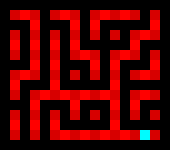

In [13]:
example = random.randrange(x_input_raw.shape[0])
print("example: "+str(example))

input_data = process_input(x_input_raw[example:example+1])

(prediction_lines, prediction_value) = model.predict(input_data)
prediction_lines_print = prediction_lines * 100
print(prediction_lines_print.astype(np.uint8))
print(np.sum(prediction_lines))
prediction = linesToDotsAndBoxesImage(prediction_lines[0], imgWidth, imgHeight)

# print input data
input_data_print = x_input_raw[example]
print("input "+str(input_data_print.shape)+": ")
print(input_data_print)

# generate greyscale image data from input data
input_imgdata = x_input_raw[example]

# print prediction
prediction_data_print = prediction * 100 
prediction_data_print = prediction_data_print.astype(np.uint8)
print("prediction policy: ")
print(prediction_data_print)

print("prediction value: ")
print(prediction_value)

print("target value: ")
print(y_value_raw[example])

# generate greyscale image data from prediction data
prediction_imgdata = prediction * 255
prediction_imgdata = prediction_imgdata.astype(np.uint8)

# generate greyscale image of target data
target_imgdata = y_policy_raw[example]

# merge image data in color channels
merged_imgdata = np.stack([input_imgdata, prediction_imgdata, target_imgdata], axis=2)

#create image
img = Image.fromarray(merged_imgdata, 'RGB')
img = img.resize(size=(img.size[0]*10, img.size[1]*10))

img